In [1]:
import glob
import numpy as np
import pandas as pd


tnrefprojs = []
tnaltprojs = []
for f in sorted(glob.glob('./sei_data/1000G_EUR_seqclass_scores/1000G*refs.npy')):
    a = np.load(f)[:,:40].astype(np.float32)
    tnrefprojs.append(a)
    b = np.load(f.replace('ref','alt'))[:,:40].astype(np.float32)
    tnaltprojs.append(b)
tnrefprojs=np.vstack(tnrefprojs)
tnaltprojs=np.vstack(tnaltprojs)

tlouvain=np.load('./sei_data/1000Genomes.2015_08.ALL.hg38.bed.vcf.af.louvain.npy')
tvcfs = pd.read_csv('./data/1000Genomes.2015_08.ALL.hg38.bed.vcf.af',sep='\t',header=None)
cnames = pd.read_csv('../resources/cnames.tsv',sep='\t')
cnames=cnames.iloc[np.argsort(cnames['index']),:]

/mnt/home/kchen/anaconda3/envs/sei-manu/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3146: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
from scipy.stats import sem

cymeans=[]
cysems=[]
cyseps = []
cNs = []


for i in range(40):
    i = [i]
    ind =   np.isin(tlouvain,i)


    diffproj = tnaltprojs[:,np.array(i)][ind,:] - tnrefprojs[:,np.array(i)][ind,:]
    diffproj = diffproj.mean(axis=1)

    ysep = np.concatenate([np.quantile(diffproj[diffproj<0],[0.01,0.1]),[0], \
                            np.quantile(diffproj[diffproj>0],[0.9,0.99])])


    ymean=[]
    ysem = []
    Ns = []
    label = tvcfs[5].values[ind] > 0.01


    bins = pd.cut(diffproj,np.concatenate([[float('-Inf')],ysep,[float('Inf')]]) , labels=False)

    for j in range(len(ysep)+1):
        ymean.append(np.nanmean(label[bins==j]))
        ysem.append(sem(label[bins==j],nan_policy='omit'))
        Ns.append(np.nansum(bins==j))
        
    cymeans.append(ymean)
    cysems.append(ysem)
    cyseps.append(ysep)
    cNs.append(Ns)




In [3]:
pd.DataFrame({'mean': np.concatenate(cymeans),
              'sem': np.concatenate(cysems),
              'Bin': np.tile(np.arange(6),40),
             'C': np.repeat(np.arange(40),6)}).to_csv('./sei_data/MAFcommon0.01.1000g.tsv',sep='\t')
              

In [4]:
import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
from scipy import stats


mean_y = []
for i in range(40):
    ind = tlouvain==i
    diffproj = tnaltprojs[:,i][ind] - tnrefprojs[:,i][ind]
    label = tvcfs[5].values[ind]>0.01
    mean_y.append(np.mean(label))


    
npv = []
nt  = []
ncoef = []
ncoef_se = []
nmean_y = []
for i in range(40):

    ind = tlouvain==i
    diffproj = tnaltprojs[:,i][ind] - tnrefprojs[:,i][ind] 
    diffproj /= np.std(diffproj)
    
    filtered = diffproj<0
    label = tvcfs[5].values[ind] > 0.01

    X2 = sm.add_constant(np.abs(diffproj[filtered,None]))
    est = Logit(label[filtered], X2)
    est2 = est.fit()
    
    npv.append(est2.pvalues[1])
    ncoef.append(est2.params[1])
    ncoef_se.append(est2.bse[1])
    nt.append(est2.tvalues[1])
    nmean_y.append(np.mean(label))


ppv = []
pt  = []
pcoef = []
pcoef_se = []
pmean_y = []
for i in range(40):
    ind = tlouvain==i
    diffproj = tnaltprojs[:,i][ind] - tnrefprojs[:,i][ind]
    diffproj /= np.std(diffproj)
    
    filtered = diffproj>0
    label = tvcfs[5].values[ind]>0.01


    X2 = sm.add_constant(np.abs(diffproj[filtered,None]))
    est = Logit(label[filtered], X2)
    est2 = est.fit()
    ppv.append(est2.pvalues[1])
    pcoef.append(est2.params[1])
    pcoef_se.append(est2.bse[1])
    pt.append(est2.tvalues[1])
    pmean_y.append(np.mean(label))


Optimization terminated successfully.
         Current function value: 0.427664
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.444819
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.373486
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.418212
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.457648
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.423397
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.438539
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.433222
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.449778
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.415216
  

In [5]:
%load_ext rpy2.ipython

In [6]:
from statsmodels.stats.multitest import multipletests 
def onesided(twosidedps, ts):
    return [p/2 if t<0 else 1-p/2  for p,t in zip(twosidedps,ts)]

fdr = np.fmax(multipletests(onesided(npv, nt), method='fdr_bh')[1],
        multipletests(onesided(ppv, pt), method='fdr_bh')[1])

R[write to console]: Loading required package: ggplot2

R[write to console]: Loading required package: ggrepel

R[write to console]: Loading required package: data.table

R[write to console]: data.table 1.13.6 using 20 threads (see ?getDTthreads).  Latest news: r-datatable.com

R[write to console]: Saving 8 x 8 in image



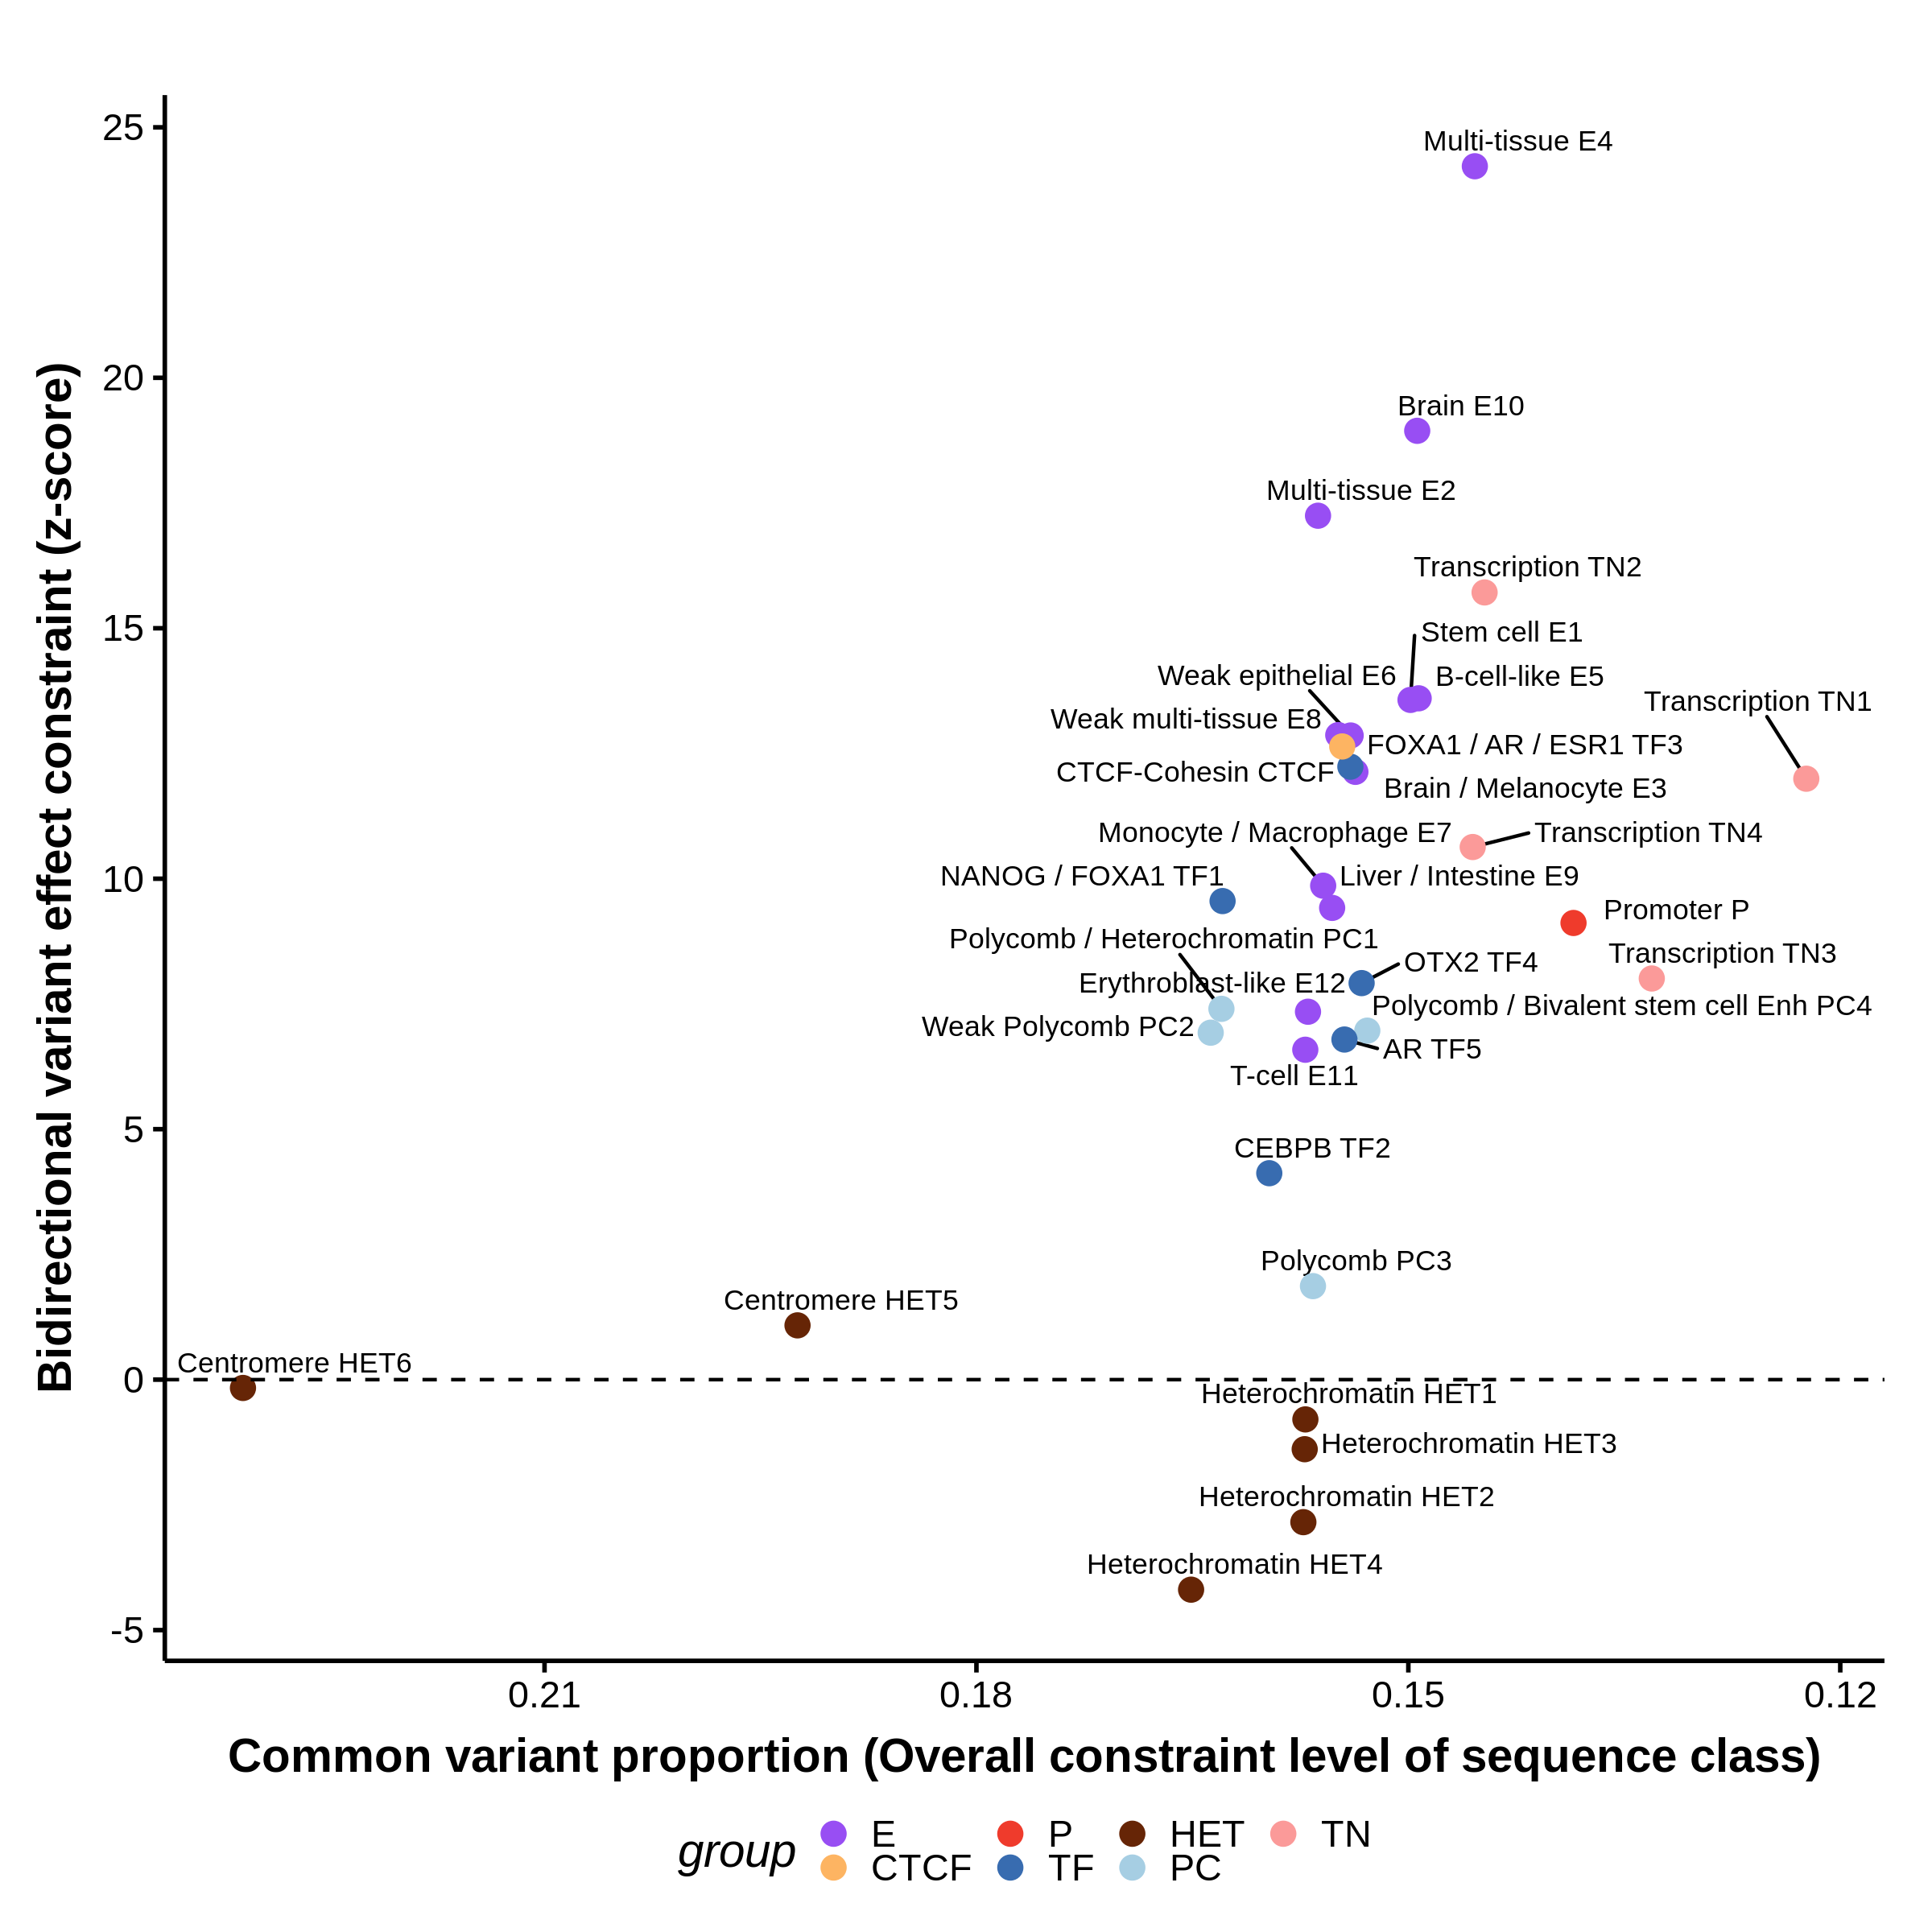

In [7]:
%%R -i cnames,mean_y,pt,nt,pcoef,ncoef,pcoef_se,ncoef_se,pmean_y,nmean_y,mean_y,fdr -w 8 -h 8 --units in -r 300

require(ggplot2)
require(ggrepel)
require(data.table)
#cnames$group = gsub('[0-9]*','',cnames$label)
cnames$group = factor(cnames$group,levels= c('E','CTCF','P','TF','HET','PC','TN','L'))

theme_Publication <- function(base_size=14, base_family="helvetica") {
      library(grid)
      library(ggthemes)
      (theme_foundation(base_size=base_size, base_family=base_family)
       + theme(plot.title = element_text(face = "bold",
                                         size = rel(1.2), hjust = 0.5),
               text = element_text(),
               panel.background = element_rect(colour = NA),
               plot.background = element_rect(colour = NA),
               panel.border = element_rect(colour = NA),
               axis.title = element_text(face = "bold",size = rel(1)),
               axis.title.y = element_text(angle=90,vjust =2),
               axis.title.x = element_text(vjust = -0.2),
               axis.text = element_text(), 
               axis.line = element_line(colour="black"),
               axis.ticks = element_line(),
               panel.grid.major = element_blank(),
               panel.grid.minor = element_blank(),
               legend.key = element_rect(colour = NA),
               legend.position = "bottom",
               legend.direction = "horizontal",
               legend.key.size= unit(0.2, "cm"),
               legend.margin = unit(0, "cm"),
               legend.title = element_text(face="italic"),
               plot.margin=unit(c(10,5,5,5),"mm"),
               strip.background=element_rect(colour="#f0f0f0",fill="#f0f0f0"),
               strip.text = element_text(face="bold")
          ))
      
}

z_score = -(unlist(pcoef)/unlist(pcoef_se)+unlist(ncoef)/unlist(ncoef_se))/sqrt(2)


plotdata = data.table(x =  unlist(mean_y), y= z_score, 
                    label = paste(cnames$name, cnames$ID),
                     group = cnames$group)
p = ggplot(plotdata[group!='L',])+geom_text_repel(aes(x= x, y = y, 
                             label=label),size=I(3),
                        nudge_x=0.003,nudge_y=0.5,max.time=6,max.iter=60000)+
    geom_point(aes(x= x, y =  y,  
                   color=group),size=I(3))+
    #geom_vline(xintercept=0.157100,linetype=2)+
    geom_hline(yintercept=0,linetype=2)+
    theme_Publication()+scale_x_reverse()+
    scale_color_manual(values=c("#984ef3","#fdb462","#ef3b2c","#386cb0","#662506","#a6cee3","#fb9a99","#dddddd"))+
    ylab('Bidirectional variant effect constraint (z-score)')+
xlab('Common variant proportion (Overall constraint level of sequence class)')

ggsave('./figures/evo.1000g.overall.pdf',device=cairo_pdf)


p